## Imports

In [1]:
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
import sklearn  as skl

from sklearn import pipeline      # Pipeline
from sklearn import preprocessing # OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import linear_model    # LogisticRegression
from sklearn import set_config

set_config(display='diagram') # Useful for display the pipeline

print("Pandas  ", pd.__version__)
print("Sklearn ", skl.__version__)

Pandas   1.2.0
Sklearn  0.23.2


## Get the dataset
- **CLOUD = True**: Download dataset from Kaggle. Necesary for cloud enviroments like COLAB. **Specify your [kaggle credentials](https://www.kaggle.com/docs/api)**.
- **CLOUD = False**: Get the dataset from your local machine. **Specify the data path**.

In [2]:
CLOUD = False

if CLOUD:
    import os
    os.environ['KAGGLE_USERNAME'] = "your_kaggle_username"
    os.environ['KAGGLE_KEY']      = "your_kaggle_api_key"  # See https://www.kaggle.com/docs/api
    !pip install --upgrade kaggle
    !kaggle competitions download -c titanic
    DATA_PATH = "./"

else:
    DATA_PATH = "../../datasets/titanic/"

## Load data

In [3]:
df      = pd.read_csv(DATA_PATH + "train.csv", index_col='PassengerId')
df_test = pd.read_csv(DATA_PATH + "test.csv",  index_col='PassengerId')

print("Train DataFrame:", df.shape)
print("Test DataFrame: ", df_test.shape)
df.head(5)

Train DataFrame: (891, 11)
Test DataFrame:  (418, 10)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Check missings

In [4]:
df.isnull().sum() / len(df)

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

In [5]:
df_test.isna().sum() / len(df_test) # Fare has Missings only in TEST !!!

Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.205742
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.002392
Cabin       0.782297
Embarked    0.000000
dtype: float64

# Preprocessing
For X data:
- We drop Survived because is the target variable
- We drop Name for simplicity. (We could extract Mr, Mrs, ...)
- We drop Ticket because it has no information -> see df.Ticket.nunique()
- We drop Cabin because it has a lot of missings (77% are missings)

Then, we identify **numerical** variables and **categorical** variables,

In [6]:
x = df.drop(columns=["Survived", 'Name', 'Ticket', 'Cabin']) # X DATA (WILL BE TRAIN+VALID DATA)
y = df["Survived"] # 0 = No, 1 = Yes

x_test = df_test.drop(columns=['Name', 'Ticket', 'Cabin']) # # X_TEST DATA (NEW DATA)

# Validation Strategy

Simple split:
- 80% for train
- 20% for validation

In [7]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x, y,
    test_size=0.2,
    stratify = y,   # ALWAYS RECOMMENDED FOR BETTER VALIDATION
    random_state=4  # Recommended for reproducibility
)

# Prepro

In [8]:
cat_vars  = ['Sex', 'Embarked']
num_vars  = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

print("\nNumerical features:\n", num_vars)
print("\nCategorical features:\n", cat_vars)


Numerical features:
 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Categorical features:
 ['Sex', 'Embarked']


In [9]:
#x.isnull().sum()

In [10]:
#x_test.isnull().sum()

In [12]:
num_preprocessing = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean', add_indicator=False)), # mean, median
    ('scaler', preprocessing.StandardScaler())
])

cat_preporcessing = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore'))
])

prepro = compose.ColumnTransformer(transformers=[
    ('num', num_preprocessing, num_vars),
    ('cat', cat_preporcessing, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked'])])

In [13]:
x_train_prepro  = prepro.fit_transform(x_train)  # ONLY FIT THE PREPROCESSOR ON TRAIN TO AVOID DATA LEAKS !!!
x_val_prepro    = prepro.transform(x_val)

x_train_prepro.shape, x_val_prepro.shape

((712, 11), (179, 11))

# Check our preprocesed data

In [14]:
cat_vars_oh = prepro.named_transformers_["cat"]["onehot"].get_feature_names(cat_vars).tolist()
cat_vars_oh

['Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Embarked_missing']

In [15]:
pd.DataFrame(data = x_train_prepro, columns=num_vars+cat_vars_oh).head() # X DATA (WILL BE TRAIN+VALID DATA)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing
0,-0.343748,-0.533095,-0.476604,-0.460631,-0.401127,0.0,1.0,0.0,0.0,1.0,0.0
1,0.844352,0.589697,0.435605,5.774523,-0.026153,1.0,0.0,0.0,0.0,1.0,0.0
2,0.844352,-1.506182,2.260023,2.033431,-0.097273,0.0,1.0,0.0,0.0,1.0,0.0
3,-1.531848,-1.057065,-0.476604,-0.460631,1.097751,1.0,0.0,0.0,0.0,1.0,0.0
4,0.844352,-2.198570,1.347814,0.786400,-0.273502,1.0,0.0,1.0,0.0,0.0,0.0


In [16]:
pd.DataFrame(data = x_val_prepro, columns=num_vars+cat_vars_oh).head() # X_TEST DATA (NEW DATA)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing
0,-1.531848,-9.125345e-03,-0.476604,-0.460631,0.494717,1.0,0.0,1.0,0.0,0.0,0.0
1,0.844352,5.318613e-16,-0.476604,-0.460631,0.485878,0.0,1.0,0.0,0.0,1.0,0.0
2,0.844352,-1.955299e+00,-0.476604,0.786400,-0.392629,1.0,0.0,1.0,0.0,0.0,0.0
3,-1.531848,5.318613e-16,-0.476604,-0.460631,-0.060566,0.0,1.0,1.0,0.0,0.0,0.0
4,0.844352,5.318613e-16,-0.476604,-0.460631,-0.508190,1.0,0.0,0.0,1.0,0.0,0.0


# Train Model

In [17]:
model = linear_model.LogisticRegression(max_iter=2000, random_state=1)
model.fit(x_train_prepro, y_train)

LogisticRegression(max_iter=2000, random_state=1)

## Full Pipeline: Prepro + Model

In [18]:
full_model = pipeline.Pipeline([('preprocessor', prepro), ('model', model)])
full_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('model', LogisticRegression(max_iter=2000, random_state=1))])

# Validate

See performance metrics like:
- Accuracy
- Balanced Accuracy
- Confusion matrix

In [19]:
# Get Predictions
y_pred       = model.predict(x_val_prepro)
y_pred_proba = model.predict_proba(x_val_prepro)[:, 1]

y_pred[:3], y_pred_proba[:3]

(array([1, 0, 1]), array([0.95078729, 0.09581055, 0.82326738]))

Accuracy:           81.56424581005587
Balanced accuracy:  80.13833992094861
Log loss:           0.44200971812043344
AUC:                85.49407114624505


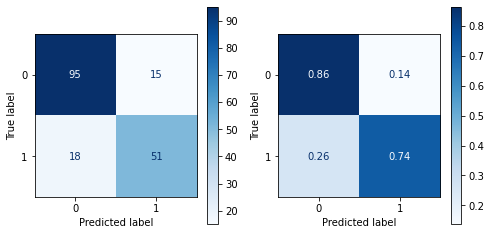

In [20]:
# See metrics
print("Accuracy:          ", metrics.accuracy_score(y_val, y_pred)*100)
print("Balanced accuracy: ", metrics.balanced_accuracy_score(y_val, y_pred)*100)
print("Log loss:          ", metrics.log_loss(y_val, y_pred_proba))
print("AUC:               ", metrics.roc_auc_score(y_val, y_pred_proba)*100) # Area Under ROC Curve


_, axes = plt.subplots(1, 2, figsize=(8, 4))
metrics.plot_confusion_matrix(model, x_val_prepro, y_val,
                      cmap=plt.cm.Blues, normalize=None,
                      ax=axes[0]);

metrics.plot_confusion_matrix(model, x_val_prepro, y_val,
                      cmap=plt.cm.Blues, normalize="true",
                      ax=axes[1]);

## See cofficients (Only for linear models)

In [21]:
coefs = pd.DataFrame(data=model.coef_[0].tolist(), index=num_vars+cat_vars_oh, columns=["Coefs"]).sort_values(by="Coefs")
coefs

,Coefs
Sex_male,-1.335175
Pclass,-0.890354
Age,-0.415987
Embarked_S,-0.257046
SibSp,-0.253253
Embarked_Q,-0.095504
Parch,-0.061410
Fare,0.044896
Embarked_C,0.165794
Embarked_missing,0.179517


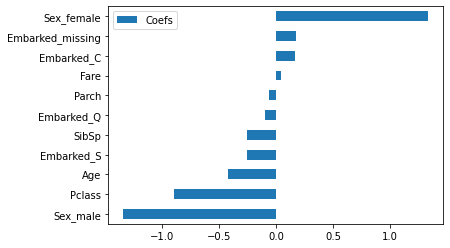

In [22]:
coefs.plot.barh();